In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.datasets import make_classification

In [2]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.6.0


In [3]:
def make_spirals(n_samples, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_samples,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_samples,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_samples,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_samples),np.ones(n_samples))))

In [4]:
from sklearn import datasets
noise = 100
n_features = 100

X, y = datasets.make_regression(n_samples=500, n_features=n_features, noise=noise)
#X1, y1 = datasets.make_moons(n_samples=200, noise=no)
#X11 = np.array([[x + 2, yy] for x, yy in X1])
#X = np.concatenate((X, X11), axis=0)
#y = np.concatenate((y, y1), axis=0)
#print(X.shape)
# plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
# plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
# plt.show()

# plt.scatter(X, y)
# plt.show()


In [5]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=7)
print('len train:', len(X_train))
print('len test:', len(X_test))
# plt.plot(X_train[:, 0][y_train == 0], X_train[:, 1][y_train == 0], 'g^')
# plt.plot(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], 'bs')
# plt.show()
# plt.plot(X_test[:, 0][y_test == 0], X_test[:, 1][y_test == 0], 'g^')
# plt.plot(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1], 'bs')
# plt.show()

len train: 400
len test: 100


In [6]:
BATCH_SIZE = 32

training_dataset = TensorDataset(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).float())
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.from_numpy(X_test).float(), 
                                torch.from_numpy(y_test).float())
test_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Define accuracy & Model

In [7]:
def accuracy(model, test_loader, l=200):
#     correct = 0
#     losses = []
#     for examples, labels in test_loader:
#         output = model.forward(examples)
#         batch_correct = torch.sum(torch.abs(torch.flatten(output) - labels) < 0.5)
#         losses.append(nn.BCELoss()(torch.flatten(output), labels))
#         correct += batch_correct

#     acc = float(correct)/l
#     loss = sum(losses)/len(losses)
#     return acc, loss
    return 1.0

def accuracy_per_data(model, inputs, labels):
    inp = Variable(inputs, requires_grad=True)
    outputs = model.forward(inp)
    loss = nn.BCELoss()(torch.squeeze(outputs), labels)
    correct = torch.sum(torch.abs(torch.flatten(outputs) - labels) < 0.5)
    return correct//len(inputs), loss

In [8]:
class RegressionModel(nn.Module):
    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(RegressionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            #nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            #nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            #nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return self.network(x)

# The calculation for immediate sensitivity

In [9]:
def grad_immediate_sensitivity(model, criterion, inputs, labels, epoch):
    inp = Variable(inputs, requires_grad=True)
    
    outputs = model.forward(inp)
    loss = criterion(torch.squeeze(outputs), labels)
    
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    
    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p = 2)
    
    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]
    
    # (4) L2 norm of (3) - "immediate sensitivity"
    s = [torch.norm(v, p=2).numpy().item() for v in sensitivity_vec]
    
    '''
    if epoch > 5:
        print(f"inputs: ",inp)
        print(f"outputs: ", outputs)
        print(f"loss: ", loss)
        print(f"first_order_grads: ", first_order_grads)
        print(f"grad_l2_norm:: ", grad_l2_norm)
        print(f"sensitivity_vec: ", sensitivity_vec)
        print(f"sensitivies: ", s)
    '''

    loss.backward()
    return loss, s

# Train the model, calculating immediate sensitivities

In [97]:
def run_experiment(epsilon, epochs, add_noise=False, throw_out_threshold=False):
    # reset the model
    model = RegressionModel(n_features=n_features)
    model_criterion = nn.MSELoss() 
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    #epochs = 100
    #iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 25
    epsilon_iter = epsilon / epochs
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []
    train_accs = []
    test_losses = []
    all_batch_mean_sensitivities = []
    all_batch_max_sensitivities = []

    for epoch in range(epochs):
#         print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        sigmas = []

        for x_batch_train, y_batch_train in train_loader:
            plz_update = True
            
            model_optimizer.zero_grad()
            loss, batch_sensitivities = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            train_losses.append(loss)
            
            batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE
            all_sensitivities.extend(batch_sensitivities)
            all_batch_mean_sensitivities.append(np.mean(batch_sensitivities) / BATCH_SIZE)
            all_batch_max_sensitivities.append(np.max(batch_sensitivities) / BATCH_SIZE)
            
            if throw_out_threshold:
                # delete gradients?
                with torch.no_grad():
                    for p in model.parameters():
                        p.grad = None

                # throw out "bad" examples
                good_idxs = np.array(batch_sensitivities) < throw_out_threshold
                #print(len(x_batch_train[good_idxs]), 'out of', len(x_batch_train))

                # re-do the gradients
                good_xs = x_batch_train[good_idxs]
                good_ys = y_batch_train[good_idxs]
                
                if len(good_xs) / len(x_batch_train) < 0.5:
                    plz_update = False
                
                outputs = model.forward(good_xs)
                loss = model_criterion(torch.squeeze(outputs), good_ys)

                loss.backward()
                
                batch_sensitivity = min(throw_out_threshold, batch_sensitivity)

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            sigmas.append(sigma)

            if add_noise:
                with torch.no_grad():
                    for p in model.parameters():
                        p.grad += (sigma * torch.randn(1).float())

            if plz_update:
                model_optimizer.step()

        max_sensitivities.append(np.max(all_sensitivities))
        mean_sensitivities.append(np.mean(all_sensitivities))
        max_sigmas.append(np.max(sigmas))        
        mean_sigmas.append(np.mean(sigmas))
#         train_accs.append(accuracy_per_data(model, torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()))
#         test_accs.append(accuracy_per_data(model, torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()))
        
        
        #plot_decision_boundary(model, nn.BCELoss(), steps=100, title=f'Epoch {epoch}')
        
#         print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
#         print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
#         print("Max sigma for the epoch:", max_sigmas[-1])
#         print("Mean sigma for the epoch:", mean_sigmas[-1])

#         print("Accuracy:", test_accs[-1])
    return accuracy(model, test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, 
                                          mean_sigmas, test_accs, train_accs,
                                          all_batch_mean_sensitivities, all_batch_max_sensitivities, test_losses), model

# Try 1, without noise

In [101]:
final_acc, info_tuple, model = run_experiment(1, 200, False, 100)

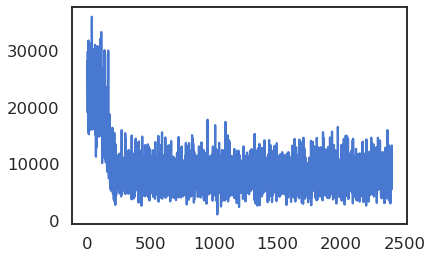

In [102]:
plt.plot(info_tuple[0])

In [103]:
lossfn = nn.MSELoss()

avg_train_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_train).float())),
                    torch.from_numpy(y_train).float())

avg_test_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_test).float())),
                    torch.from_numpy(y_test).float())

print('average train loss:', avg_test_l)
print('average test loss:', avg_test_l)

average train loss: tensor(12823.8359, grad_fn=<MseLossBackward>)
average test loss: tensor(12823.8359, grad_fn=<MseLossBackward>)


# Sensitivity stats

2400
2400


Text(0, 0.5, 'Mean Sensitivity')

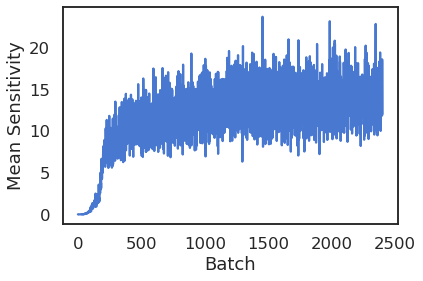

In [104]:
#the info tuple holds: (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, all_means)
batch_mean_sensitivities = info_tuple[7]
batch_max_sensitivities = info_tuple[8]
print(len(batch_max_sensitivities))
print(len(batch_mean_sensitivities))

plt.plot(batch_mean_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Mean Sensitivity")

Text(0, 0.5, 'Max Sensitivity')

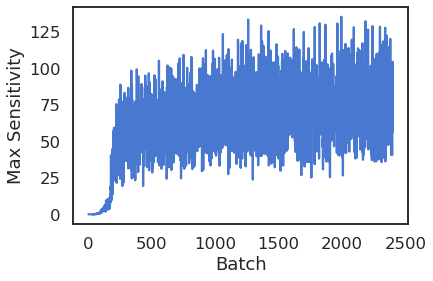

In [105]:
plt.plot(batch_max_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Max Sensitivity")

# Membership Inference Attacks

In [106]:
lossfn = nn.MSELoss()

avg_train_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_train).float())),
                    torch.from_numpy(y_train).float())

avg_test_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_test).float())),
                    torch.from_numpy(y_test).float())

print('average train loss:', avg_test_l)
print('average test loss:', avg_test_l)

average train loss: tensor(12823.8359, grad_fn=<MseLossBackward>)
average test loss: tensor(12823.8359, grad_fn=<MseLossBackward>)


In [107]:
def gaussian_pdf(sd, x):
    if sd <= 0:
        raise ValueError('standard deviation must be positive but is {}'.format(sd))
    else: #sd > 0
        return np.e ** (-0.5*(x/sd)**2) / sd


def membership_inf(model, avg_train_loss, inputs, labels):
    inp = Variable(inputs, requires_grad=True)
    
    outputs = model.forward(inp)
    loss = nn.MSELoss(reduction='none')(torch.squeeze(outputs), labels)
    pass_inf = [1 if abs(l) < avg_train_loss else 0 for l in loss]
    
    return pass_inf, [float(l) for l in loss]

In [108]:
def run_membership_inference_attack(model, avg_train_l, X_target, y_target):
    _, sensitivities = grad_immediate_sensitivity(model, 
                                                      nn.MSELoss(), 
                                                      torch.from_numpy(X_target).float(), 
                                                      torch.from_numpy(y_target).float(), 
                                                      None)
    max_sen = max(sensitivities)
    norm_sen = [s/max_sen for s in sensitivities]
    min_exp = min([np.log(s) for s in sensitivities if s != 0])
    log_sen = [np.log(s) if s !=0 else min_exp - 1 for s in sensitivities]
    paws = [s - (min_exp - 1) for s in log_sen]

    pass_inf, train_loss = membership_inf(model, 
                                          avg_train_l, 
                                          torch.from_numpy(X_target).float(), 
                                          torch.from_numpy(y_target).float())
    #plt.scatter(paws, pass_inf)
    print('positive ratio:',sum(pass_inf)/len(pass_inf))
    return sum(pass_inf)/len(pass_inf)

In [109]:
tpr = run_membership_inference_attack(model, avg_train_l, X_train, y_train)

positive ratio: 0.7575


In [110]:
fpr = run_membership_inference_attack(model, avg_train_l, X_test, y_test)

positive ratio: 0.6


In [111]:
print('Adv:', tpr - fpr)

Adv: 0.15749999999999997


NameError: name 'train_loss' is not defined

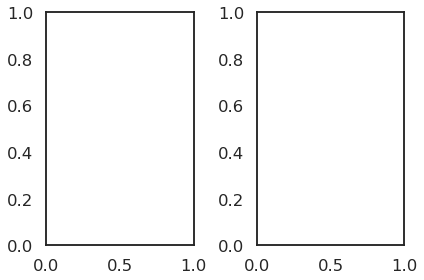

In [112]:

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].hist(train_loss, 25)
axs[0].title.set_text('Training Data')
axs[0].set_xlabel('Loss')
axs[0].set_ylabel('Count')
axs[1].hist(test_loss, 25, alpha=1)
axs[1].title.set_text('Test Data')
axs[1].set_xlabel('Loss')

# Try 2, with noise

In [170]:
final_acc, info_tuple, model = run_experiment(5.0, 200, True, 80)

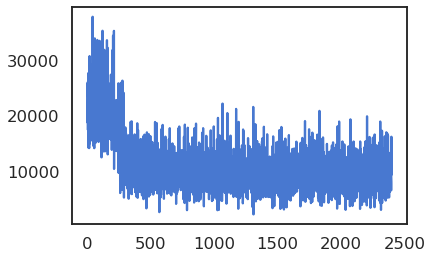

In [171]:
plt.plot(info_tuple[0])

In [172]:
lossfn = nn.MSELoss()

avg_train_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_train).float())),
                    torch.from_numpy(y_train).float())

avg_test_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_test).float())),
                    torch.from_numpy(y_test).float())

print('average test loss:', avg_test_l)

average test loss: tensor(14958.0791, grad_fn=<MseLossBackward>)


In [173]:
tpr = run_membership_inference_attack(model, avg_train_l, X_train, y_train)

positive ratio: 0.7575


In [174]:
fpr = run_membership_inference_attack(model, avg_train_l, X_test, y_test)

positive ratio: 0.62


In [175]:
print('Adv:', tpr - fpr)

Adv: 0.13749999999999996


2400
2400


Text(0, 0.5, 'Mean Sensitivity')

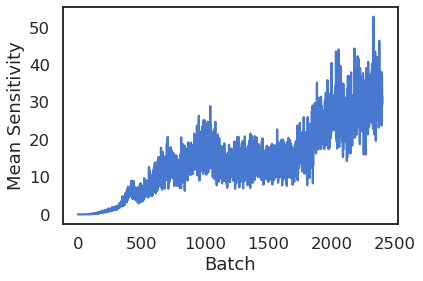

In [71]:
#the info tuple holds: (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, all_means)
batch_mean_sensitivities = info_tuple[7]
batch_max_sensitivities = info_tuple[8]
print(len(batch_max_sensitivities))
print(len(batch_mean_sensitivities))

plt.plot(batch_mean_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Mean Sensitivity")

Text(0, 0.5, 'Max Sensitivity')

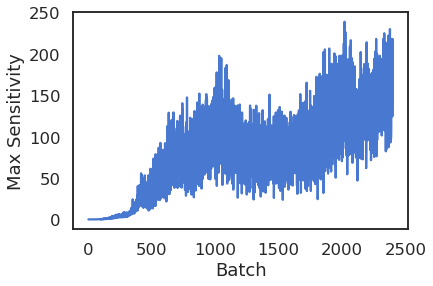

In [72]:
plt.plot(batch_max_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Max Sensitivity")